In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime


# 0. Functions

In [2]:

def daily_price(ticker, end, days_earlier=3, columns=['Close']):
    '''
    Returns a DataFrame of prices for ticker from Yahoo Finance API
    The close date is excluded!!!!
    Minimum 3 days window due to weekends and holidays.
    '''
    result_series = []

    for timestamp in end:
        start = timestamp - datetime.timedelta(days=days_earlier)

        obj = yf.Ticker(ticker)
        data = obj.history(start=start, end=timestamp)[columns]

        result_series.append(data[columns].values.mean())

    return pd.Series(result_series).values

In [3]:
def replace_format_input(input=pd.DataFrame):
    '''
    replace - characters to 0
    add missing 0-s from the end
    drop out , as separators
    set datatype to integer
    '''
    for column in input.columns:
        if isinstance(input[column][0], str):
            # create empty list to add element
            result = []
            # itreate through the columns
            for elem in input[column]:
                # checkt the value contains a ,
                if ',' in elem:
                    # if the last part of string is shorter than 3 characters
                    original_value = elem.split(',')
                    if len(original_value[-1]) < 3:
                        # create new last element of original value
                        original_value[-1] = original_value[-1].ljust(3, '0')    
                        # recreate string
                        new_value = "".join(original_value)
                    else:
                        new_value = "".join(original_value)
                    # add merged element to list
                    result.append(new_value)
                elif elem == '-':
                    # replace - to 0
                    result.append('0')
                else:
                    # add don't modified values
                    result.append(elem)
            # overwrite column values and fix datatype
            input[column] = pd.Series(result).astype(int)
    return input

In [4]:
def convert_national_currency(input_data=pd.DataFrame, currency=pd.DataFrame):
    '''
    Convert colums into national currency
    '''
    output_data = input_data.copy()

    for column in output_data.columns:
        if column not in ['shares', 'national_div', 'usd_div', 'usd_nat_currency', 'real_date', 'date']:
            output_data[column] = output_data[column].astype(float) * currency['usd_nat_currency']

    return output_data

In [5]:
def calculate_real_date(input):
    '''
    Calculate the rough estimated date when the quaterly report could be available
    '''
    result = []
    for timestamp in input['date']:
        if timestamp.month == 12:
            result.append(timestamp + datetime.timedelta(days=42))
        else:
            result.append(timestamp + datetime.timedelta(days=21))

    input['real_date'] = result
    return input

In [6]:
def filter_raw_data(input=pd.DataFrame):
    filtered = input[
                [
                'date',
                'real_date',
                'shares',
                'revenue',
                'cogs',
                'gross_profit',
                'net_profit',
                'cash',
                'acc_rec',
                'inventory',
                'curr_assets',
                'goodwill',
                'intangible_assets',
                'total_assets',
                'acc_pay',
                'short_term_debt',
                'current_debt',
                'curr_liab',
                'long_term_debt',
                'total_liab',
                'cash_from_operating_activities',
                'capex'
                ]
            ].copy()
    
    return filtered

In [7]:
def calculate_input_value_ratios(input=pd.DataFrame):
    input['eps'] = (input['net_profit'] * 4) / input['shares'] # quaterly corrected here --> multipled by 4
    input['bv_per_share'] = (input['total_assets']-input['total_liab']) / input['shares']
    input['fcf'] = (4 * input['cash_from_operating_activities']) - (input['capex'] * 4) # quaterly corrected here --> multipled by 4
    input['fcf_per_share'] = input['fcf'] / input['shares']

    return input

In [8]:
def ratios_input_filter(input=pd.DataFrame):
    ratios = input[
                [
                'date',
                'real_date',
                'revenue',
                'eps',
                'bv_per_share',
                'shares',
                'fcf',
                'fcf_per_share'
                ]
            ].copy()

    return ratios

In [9]:
def evaluate_performance(input=pd.DataFrame, output=pd.DataFrame):
    # evauleat short term debt
    output['current_ratio'] = input['curr_assets'] / input['curr_liab']
    output['quick_ratio'] = (input['curr_assets'] - input['inventory']) / input['curr_liab']
    output['cash_ratio'] = input['cash'] / input['curr_liab']
    #evaluate long term debt
    output['debt_to_equity'] = input['total_liab'] / (input['total_assets'] - input['total_liab'])
    output['equity_ratio'] = (input['total_assets'] - input['total_liab']) / input['total_assets']
    output['debt_ratio'] = input['total_liab'] / input['total_assets']
    # evlauate management --> based on efficiency ratios
    output['acc_rec_ratio'] = (4 * input['revenue']) / input['acc_rec']
    output['acc_pay_ratio'] = (-4 * input['cogs']) / input['acc_pay']
    output['cash_turnover'] = (4 * input['revenue']) / input['cash']
    output['inventory_turnover'] = (-4 * input['cogs']) / input['inventory']
    # test economy moat
    output['gross_profit_margin'] = input['gross_profit'] / input['revenue']
    output['net_profit_margin'] = input['net_profit'] / input['revenue']
    output['roa'] = (4 * input['net_profit']) / input['total_assets']
    output['roe'] = (4 * input['net_profit']) / (input['total_assets'] - input['total_liab'])

    return output

In [10]:
def price_ratios(input=pd.DataFrame):
    '''
    The original metrics have been develoed to annual data. I use quaterly data.
    '''
    input['pe_ratio'] = input['share_price'] / input['eps'] # previously multiplied by 4 (quaterly correction)
    input['pb_ratio'] = input['share_price'] / input['bv_per_share'] # don't need to quaterly correct (Income Statement data)
    input['ps_ratio'] = (input['share_price'] * input['shares']) / (input['revenue'] * 4) # quaterly corrected here --> multipled by 4
    input['pfcf_ratio'] = (input['share_price'] * input['shares']) / input['fcf']  # previously multiplied by 4 (quaterly correction)

    return input

# 1. Load raw input
## Hardcoded block

In [38]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount
## Pull historical USD national currency rates to dividend & calculate historical dividend in USD

In [39]:
# ticker_share = yf.Ticker(share_name)
# dividend = ticker_share.history(period='max', interval="1wk")
# dividend = dividend[dividend['Dividends'] > 0]
# dividend = dividend.rename(columns={'Dividends': 'local_amount'})

# dividend['real_date'] = dividend.index 
# dividend['real_date'] = dividend['real_date'].dt.tz_localize(None)

# dividend = dividend[['real_date', 'local_amount']]

# dividend['usd_rate'] = daily_price(ticker=currency_pair, end=dividend['real_date'], days_earlier=3)
# dividend['currency'] = [currency_pair.split(sep='=')[0] for x in range(len(dividend))]
# dividend['usd_dividend'] = dividend['local_amount'] / dividend['usd_rate']

# dividend.head()

## Extend your input statement table with historical dividend data and calculate share prices!

# 1.2. Raw input statement data

In [40]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [41]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,other_investing_cf_items,cash_from_investing,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,shares
0,2013-12-31,8653,-7933,720,-149,-90,7,-65,423,-32,...,-1,-1295,0,0,0,588,587,6,388,273
1,2014-03-31,8551,-8010,541,-200,-85,7,-52,211,-58,...,-7,-874,0,0,0,111,111,0,-321,273
2,2014-06-30,9438,-8607,831,-261,-113,22,-94,385,-89,...,6,-898,1,-479,0,551,73,1,994,273
3,2014-09-30,9287,-8179,1108,-182,-83,14,-72,785,-170,...,1,-718,0,0,0,-1468,-1469,0,-740,273
4,2014-12-31,9615,-8109,1506,-237,-114,2,-67,1090,-255,...,-715,-1716,-1,0,0,-69,-70,2,321,273


## Calculate date when quaterly reports could be available

In [42]:
data = calculate_real_date(data)

# 2. Filter out unnecesary columns

In [43]:
data = filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,3533,96376,10335,0,414,15832,10639,38065,7295,-3724
37,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,3517,102257,12361,0,427,17226,12301,41498,2871,-2918
38,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,3619,97568,11654,0,2598,18891,11165,42376,449,-4219
39,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
40,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804


## Pull historical average USD national currency rates and add to the dataframe

In [44]:
data['usd_nat_currency'] = daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
37,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
38,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
39,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
40,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [45]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nok = convert_national_currency(input_data=data, currency=data)
else:
    data_nok = data.copy()
data_nok.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
37,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
38,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
39,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
40,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [46]:
filtered_nok = calculate_input_value_ratios(data_nok)

## Calculate input values to value ratios

In [47]:
ratios_nok = ratios_input_filter(filtered_nok)

In [48]:
ratios_nok = evaluate_performance(input=filtered_nok, output=ratios_nok)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [49]:

obj = yf.Ticker(share_name)
yar_share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
yar_share_price['real_date'] = yar_share_price.index
# remove localization (timezone) to let merge the two columns
yar_share_price['real_date'] = yar_share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
yar_share_price['share_price'] = yar_share_price['Close']
yar_share_price = yar_share_price[['real_date', 'share_price']]

yar_share_price.tail()

,real_date,share_price
Date,,
2024-01-15 00:00:00+01:00,2024-01-15,270.700012
2024-01-22 00:00:00+01:00,2024-01-22,282.500000
2024-01-29 00:00:00+01:00,2024-01-29,270.299988
2024-02-05 00:00:00+01:00,2024-02-05,269.700012
2024-02-12 00:00:00+01:00,2024-02-12,277.500000


## Merge the statement dataset with share prices

In [50]:
merged_nok = pd.merge_asof(left=yar_share_price, right=ratios_nok, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nok = merged_nok.dropna()
merged_nok = merged_nok.reset_index(drop=True)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,69.562218,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
1,2014-02-24,68.884888,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
2,2014-03-03,66.107803,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
3,2014-03-10,62.213131,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
4,2014-03-17,62.856613,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [51]:
merged_nok = price_ratios(merged_nok)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
0,2014-02-17,69.562218,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826,12.142254,0.823561,0.548668,1.991452
1,2014-02-24,68.884888,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826,12.024025,0.815542,0.543325,1.972061
2,2014-03-03,66.107803,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826,11.539278,0.782663,0.521421,1.892558
3,2014-03-10,62.213131,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826,10.859453,0.736553,0.490702,1.781060
4,2014-03-17,62.856613,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,1.239756,...,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826,10.971775,0.744172,0.495778,1.799481


# Calculate Dividend yield and currency-share price correlation

In [52]:
obj = yf.Ticker(currency_pair)
obj2 = yf.Ticker(share_name)
usd_nok = obj.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
usd_nok['date'] = usd_nok.index
usd_nok['date'] = usd_nok['date'].dt.tz_localize(None)
usd_nok['currency_rate'] = usd_nok['Close']

In [53]:
yar_all_price = obj2.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
yar_all_price['date'] = yar_all_price.index
yar_all_price['date'] = yar_all_price['date'].dt.tz_localize(None)
yar_all_price['share_price'] = yar_all_price['Close']
yar_all_price['dividend_yield'] = yar_all_price['Dividends'] * 100 / yar_all_price['Close']

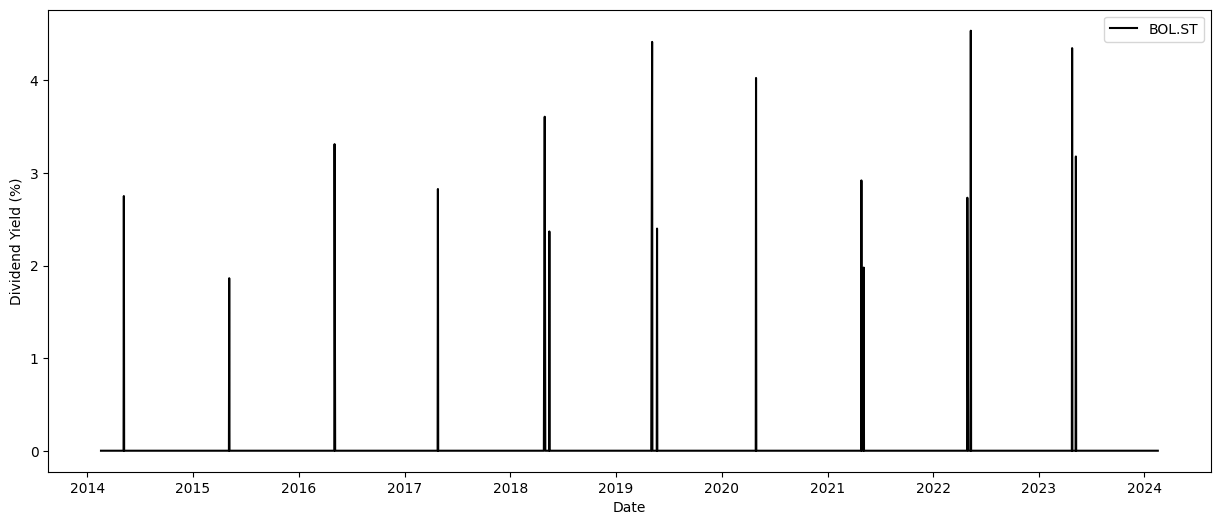

In [54]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(yar_all_price.index, yar_all_price['dividend_yield'], color='k', label=share_name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Dividend Yield (%)', color='k')

plt.legend()
plt.show()

In [55]:
share_price_currency_rate_correlation = pd.merge_asof(left=usd_nok, right=yar_all_price, on='date')
share_price_currency_rate_correlation.index = share_price_currency_rate_correlation['date']
share_price_currency_rate_correlation = share_price_currency_rate_correlation[['currency_rate', 'share_price']]

share_price_currency_rate_correlation.corr()['share_price']

currency_rate    0.707113
share_price      1.000000
Name: share_price, dtype: float64

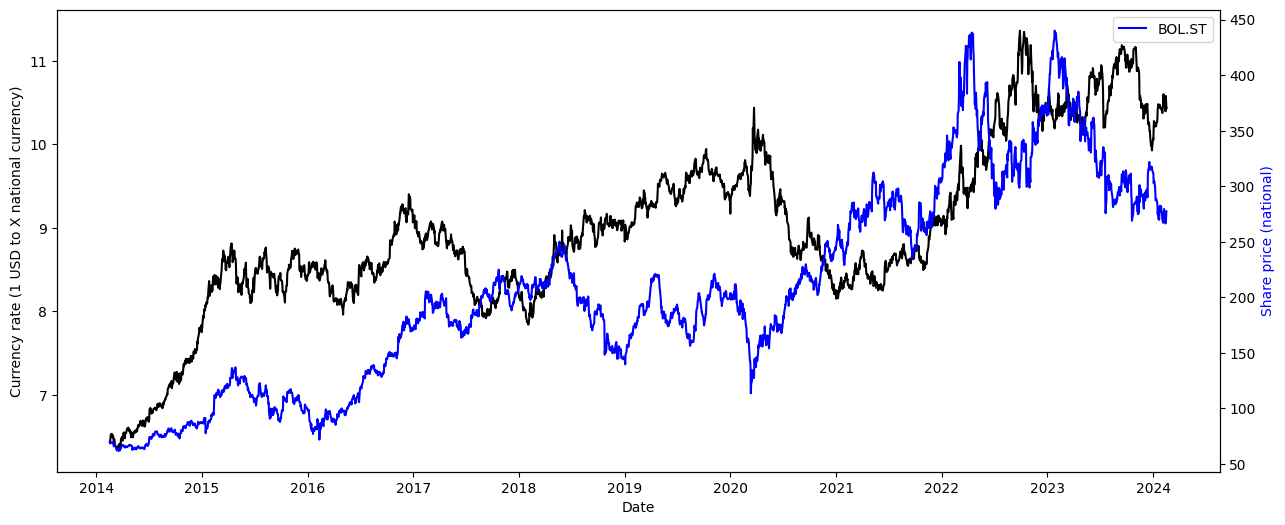

In [56]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(usd_nok.index, usd_nok['Close'], color='k', label='USD / national currency')
ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label=share_name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Currency rate (1 USD to X national currency)', color='k')
ax2.set_ylabel('Share price (national)', color='b')

plt.legend()
plt.show()

# Share price and value ratios

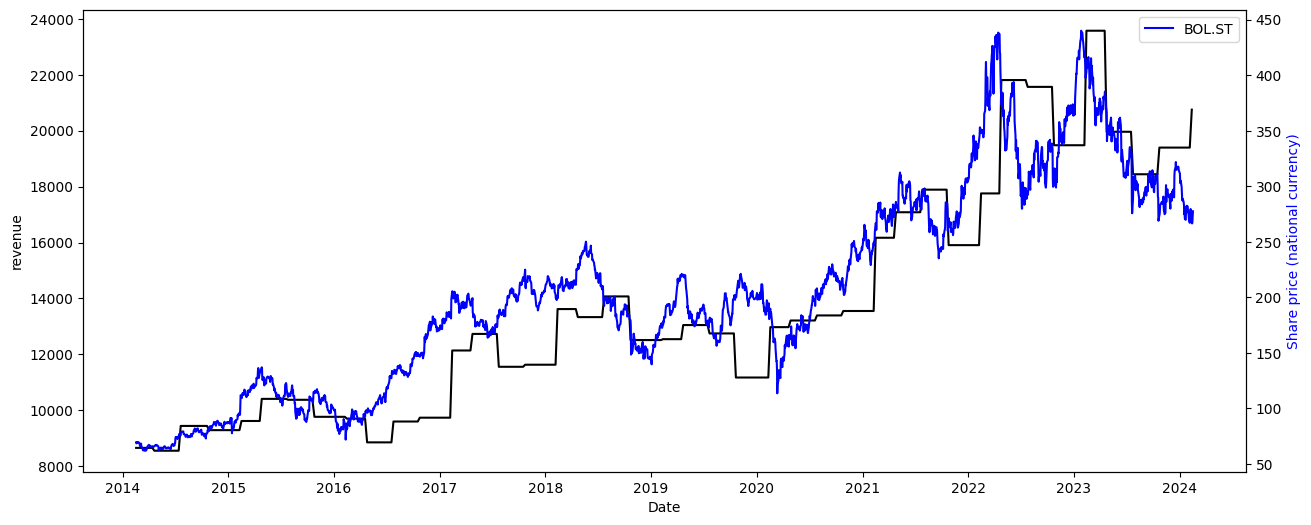

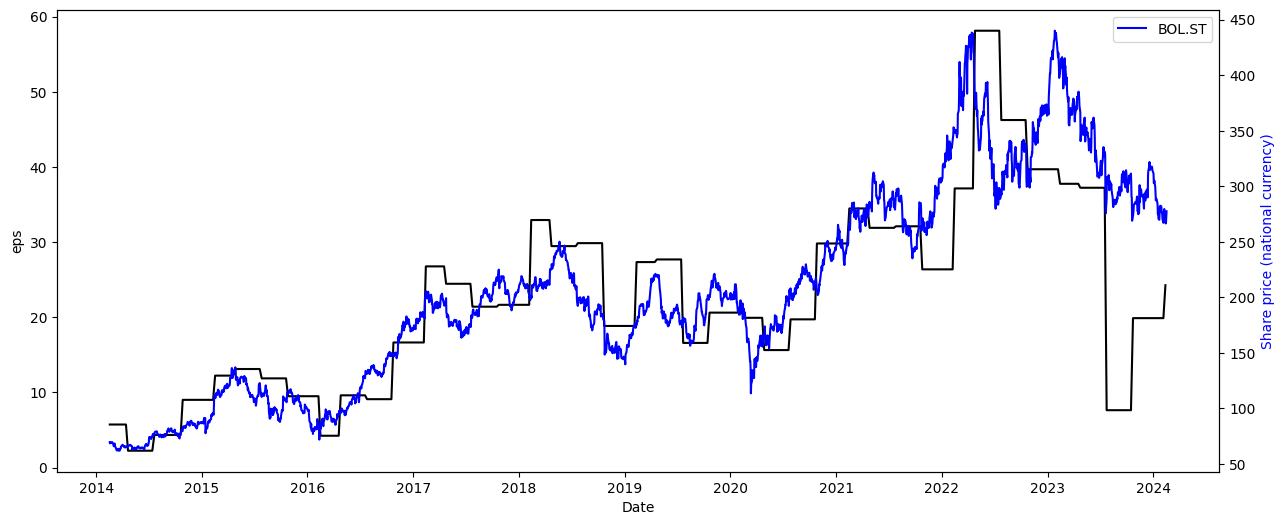

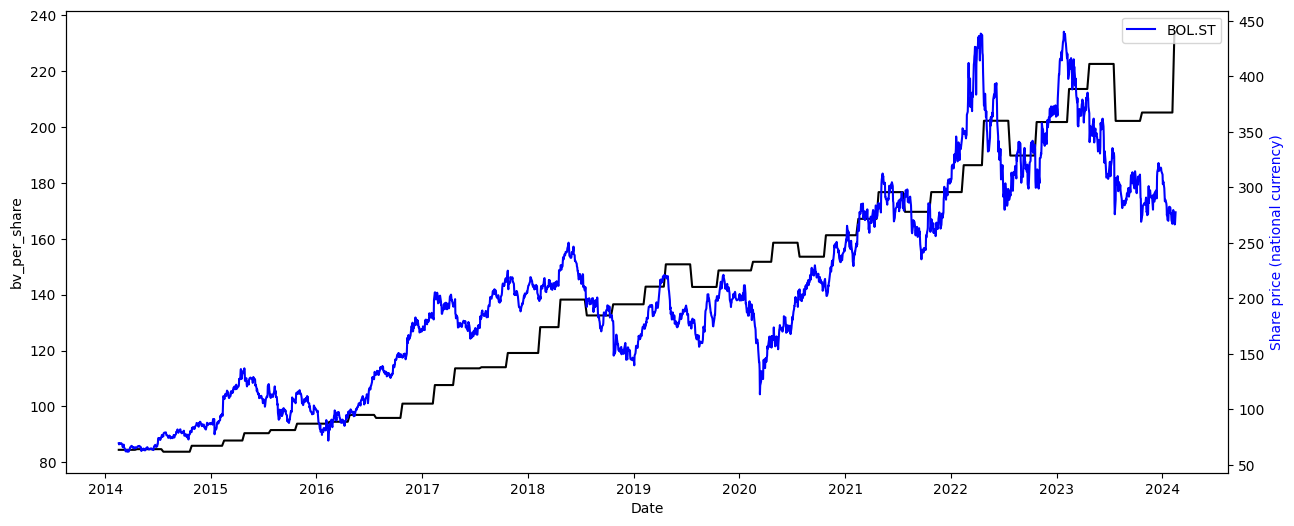

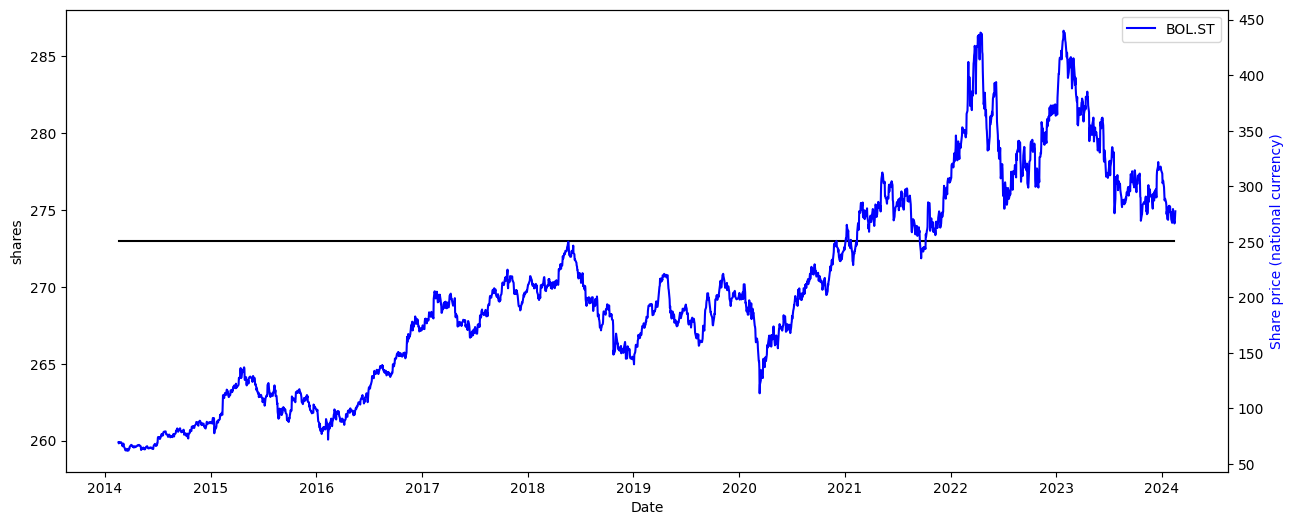

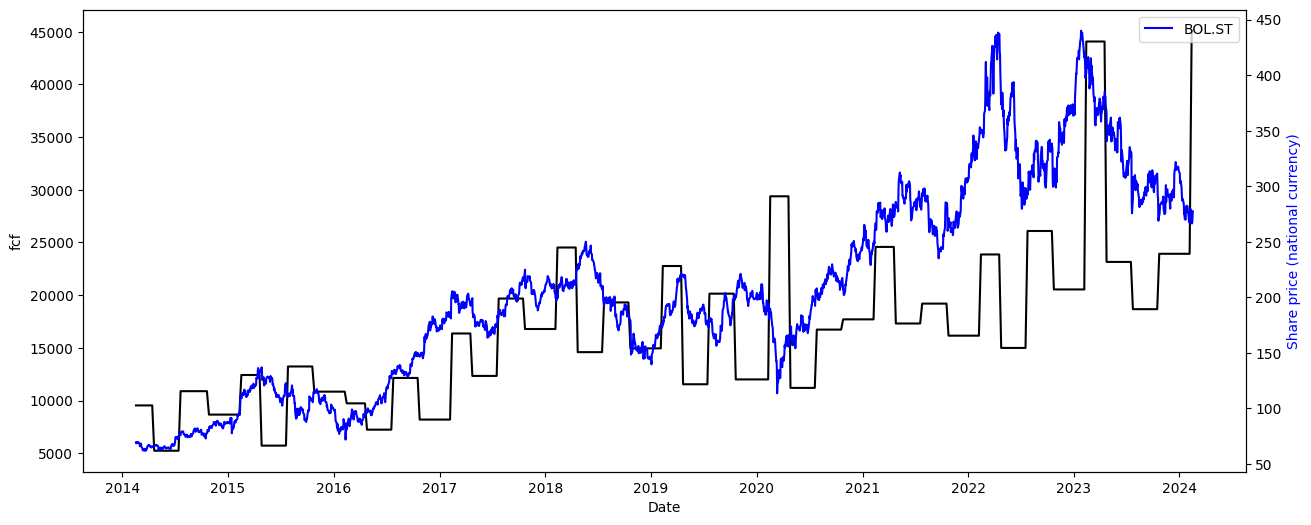

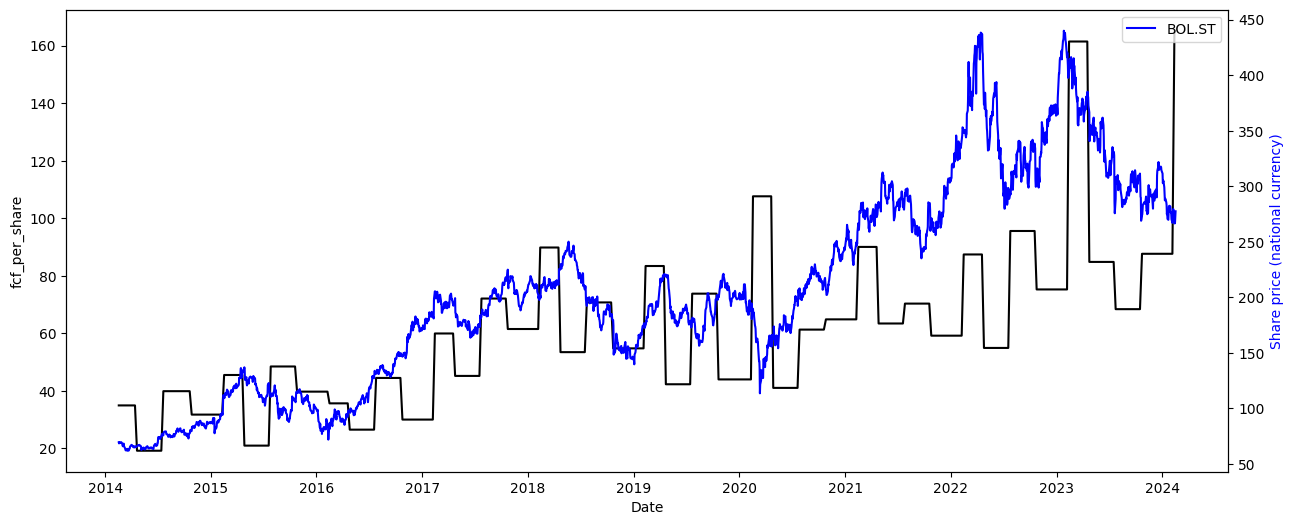

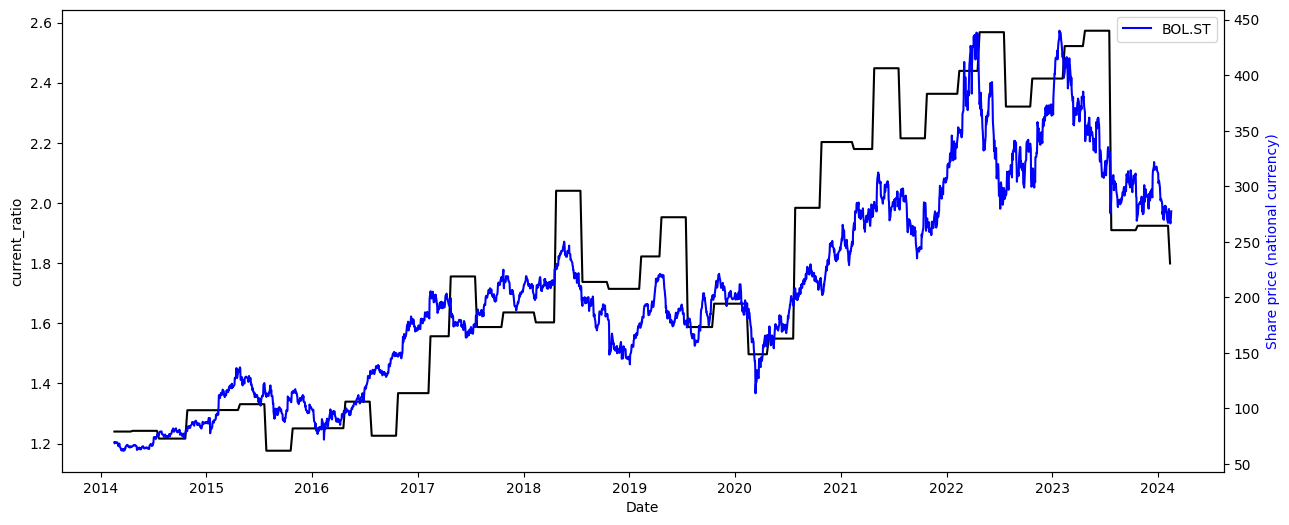

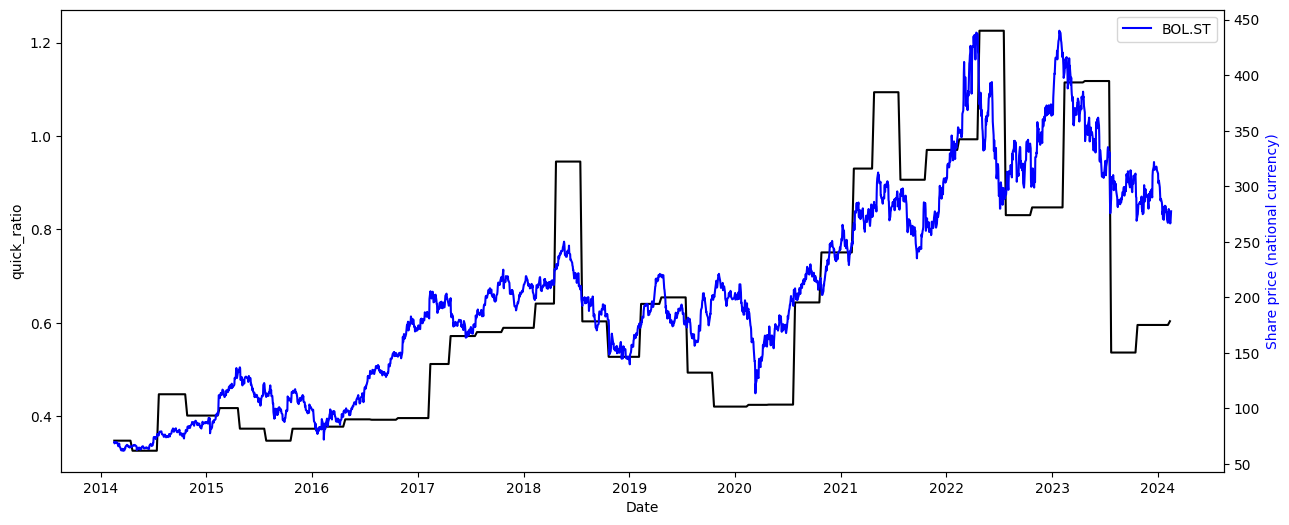

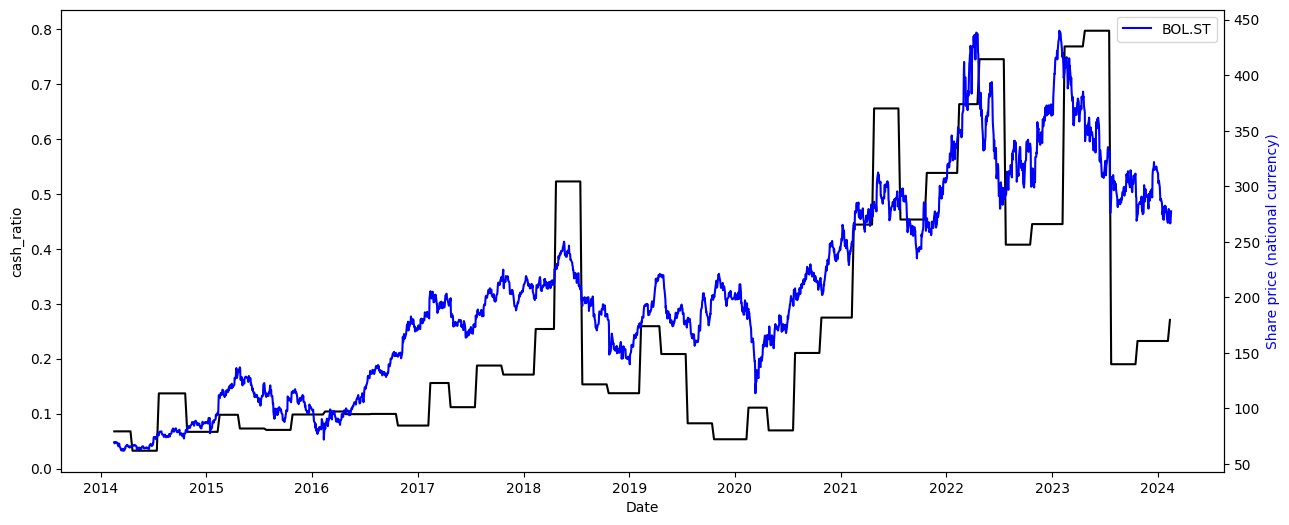

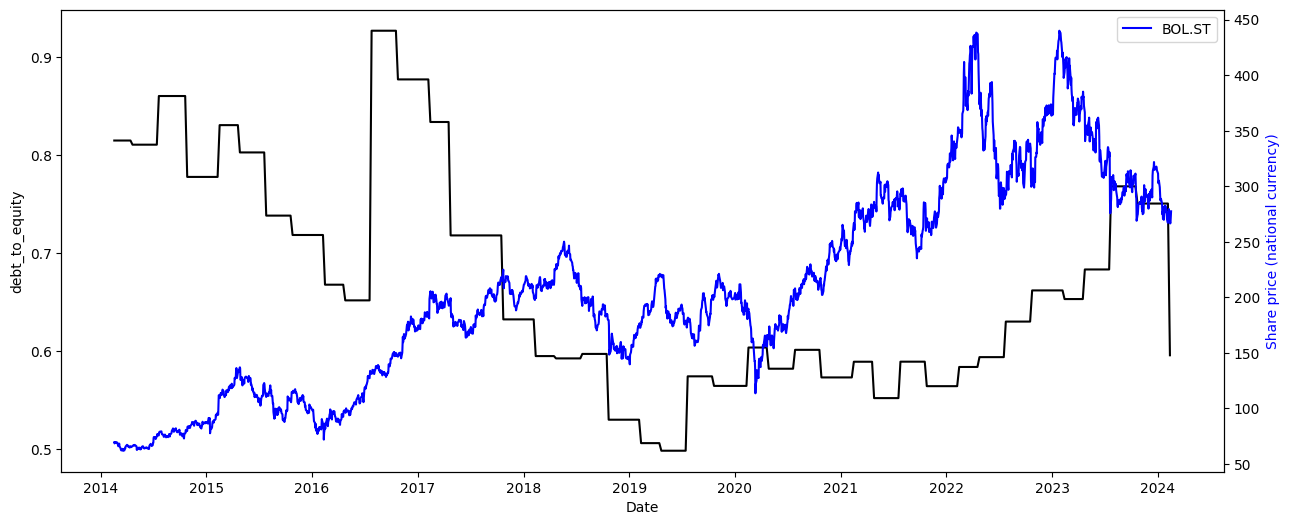

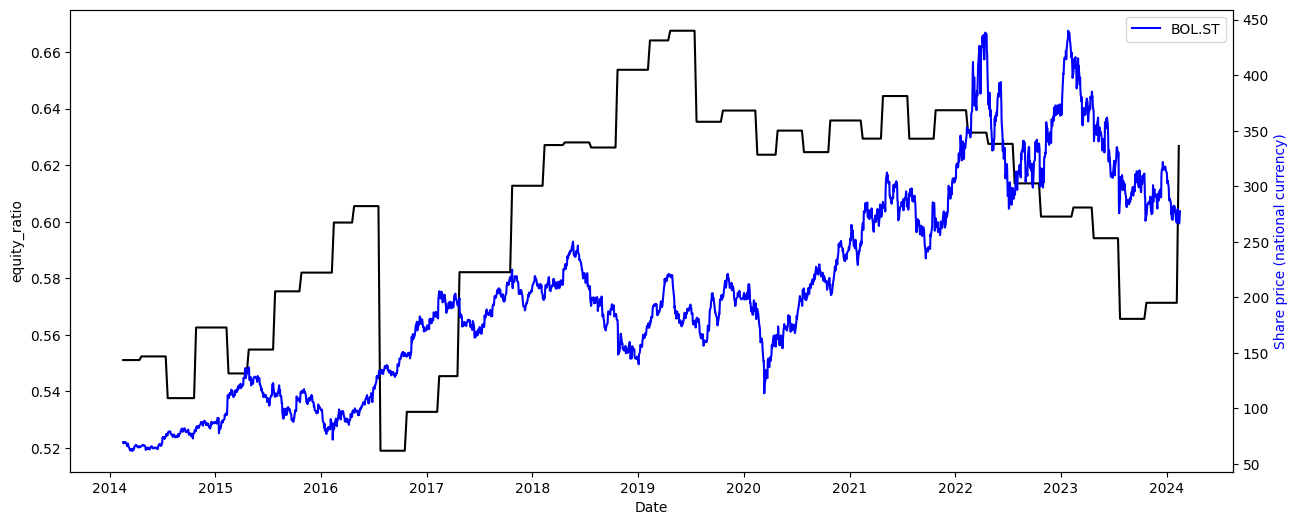

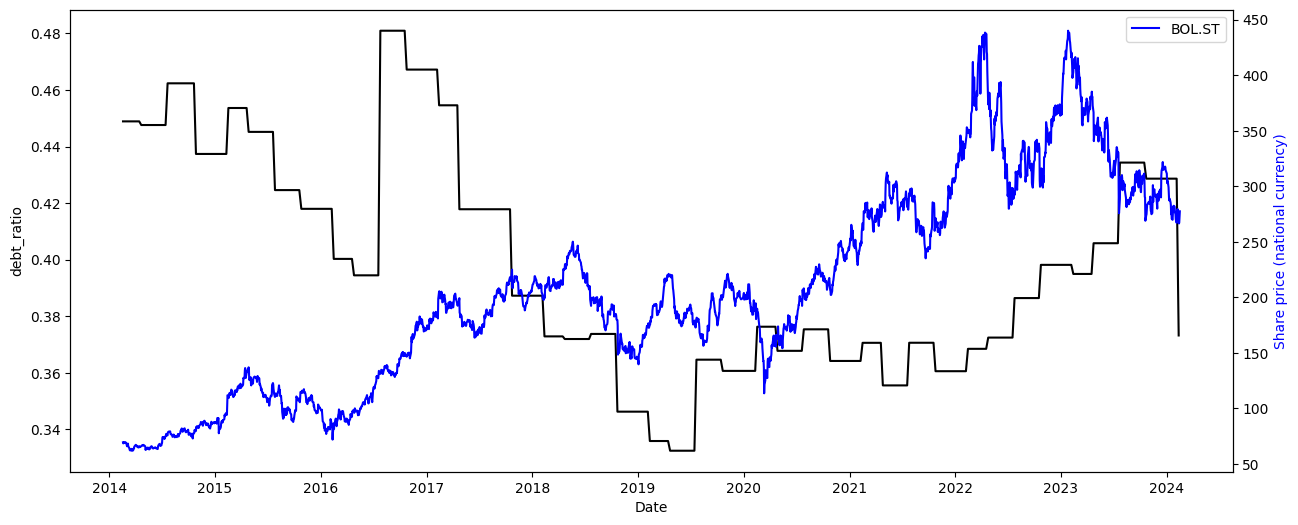

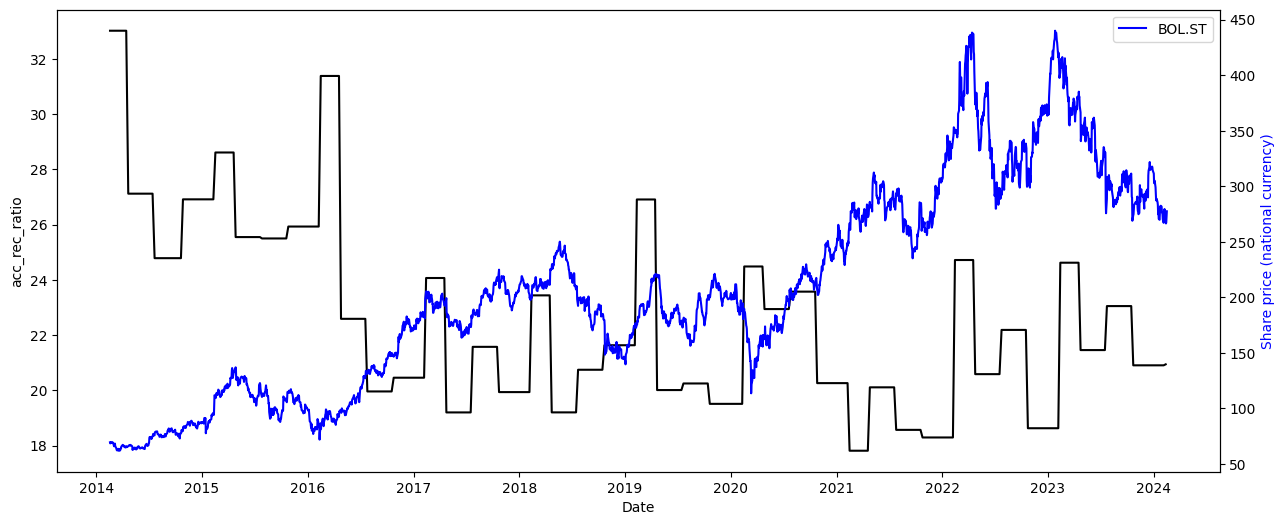

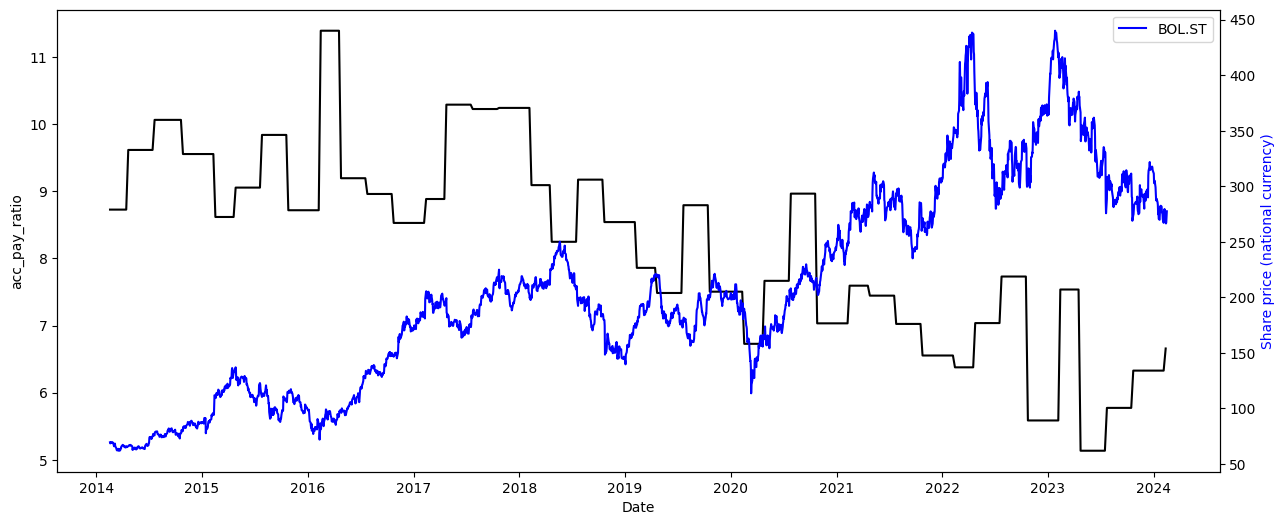

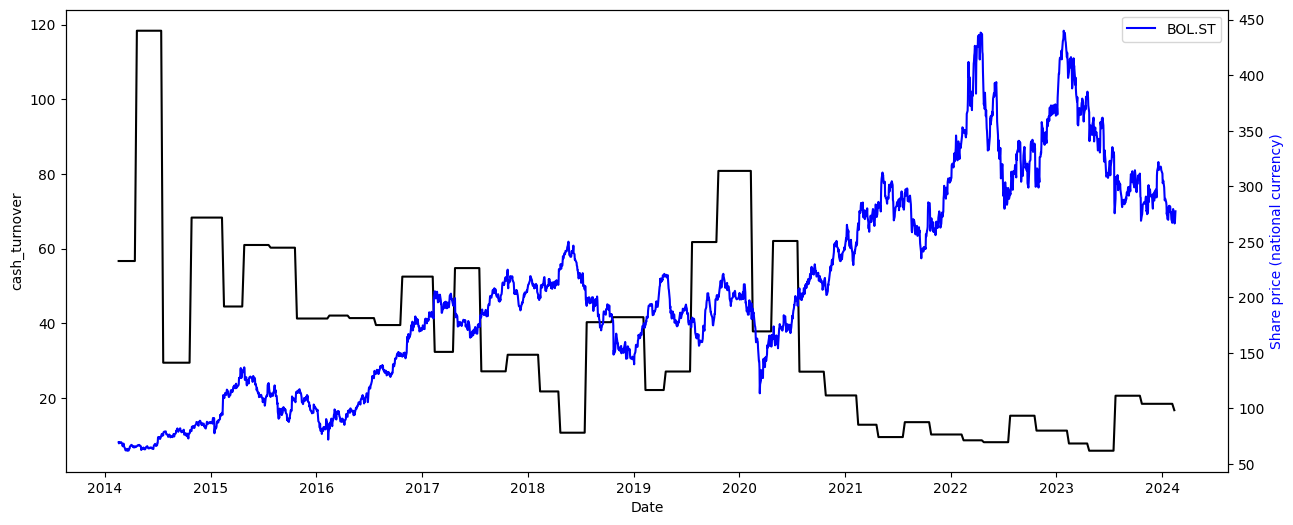

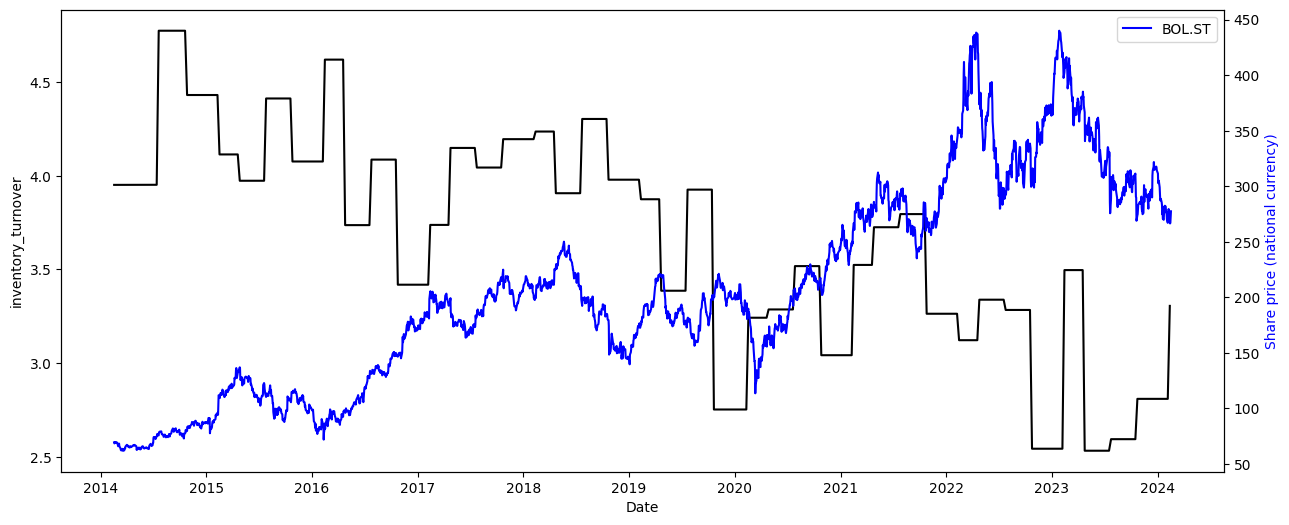

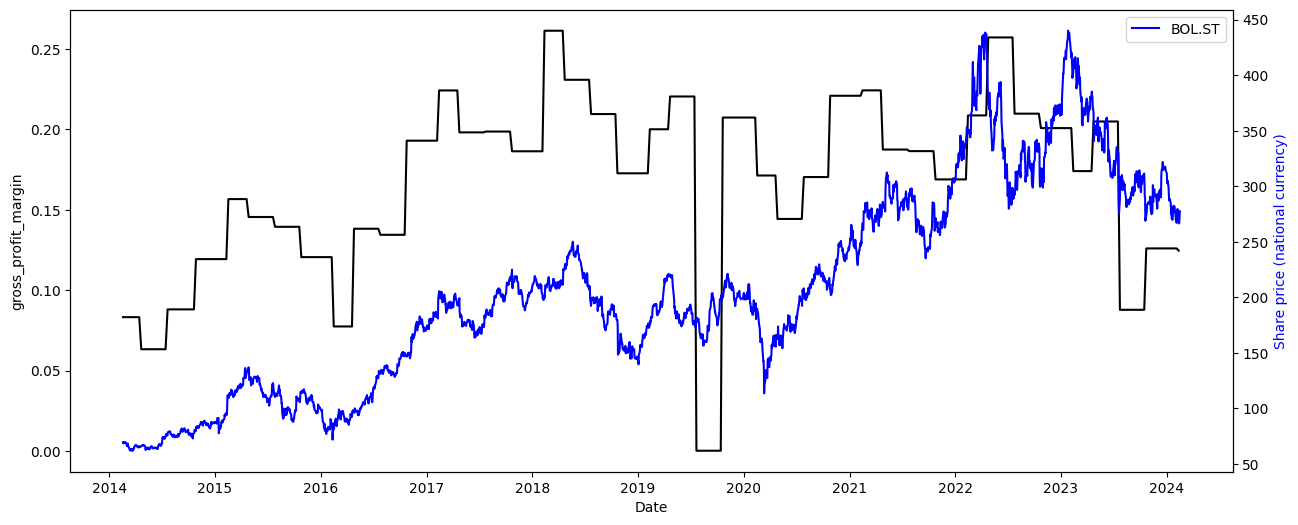

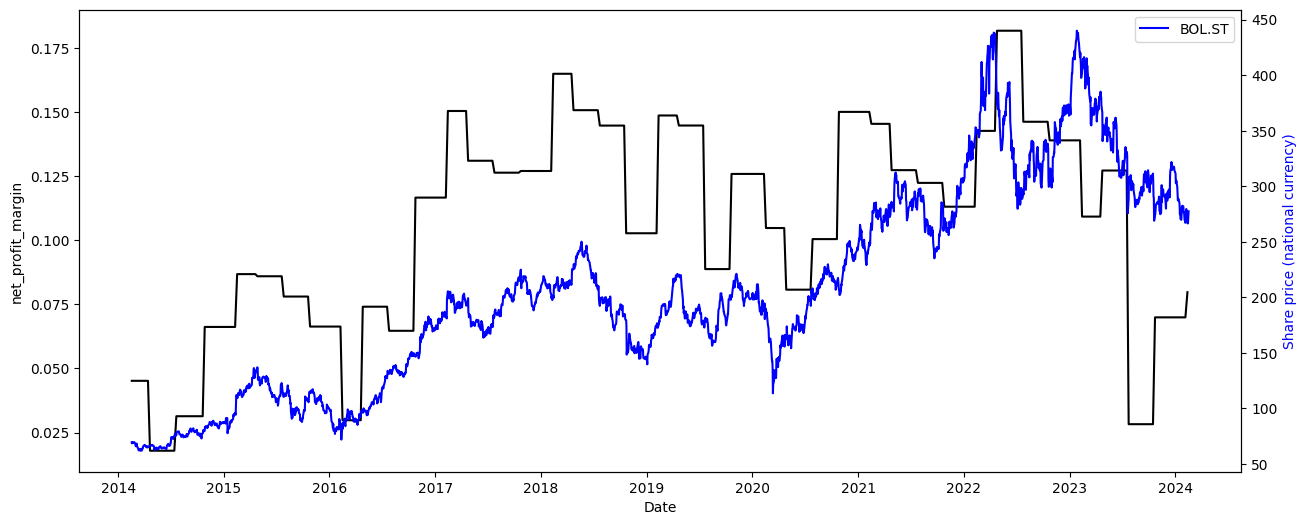

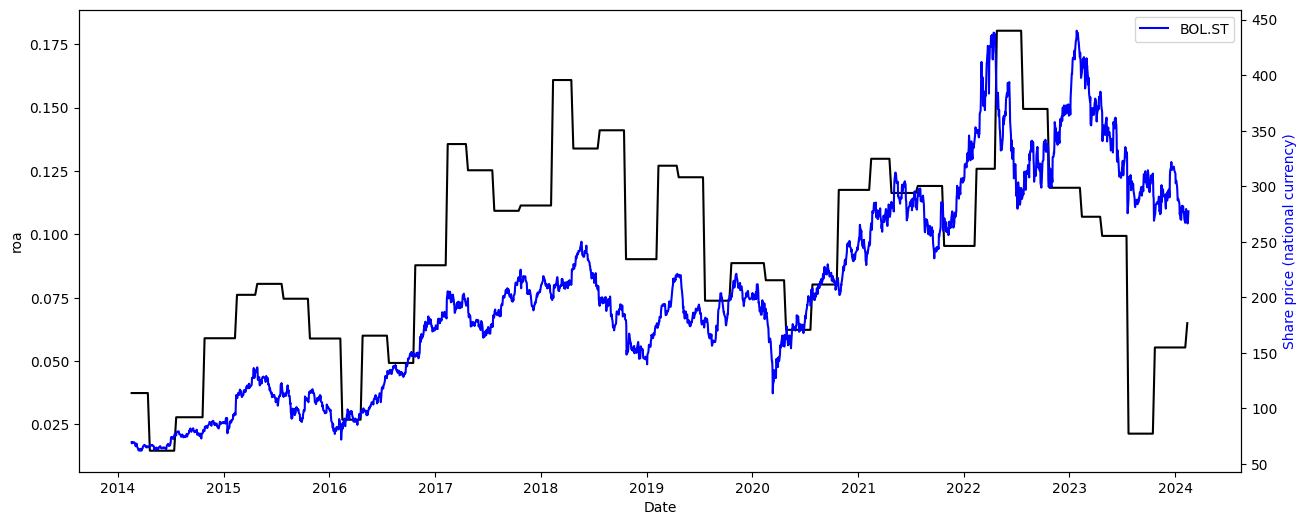

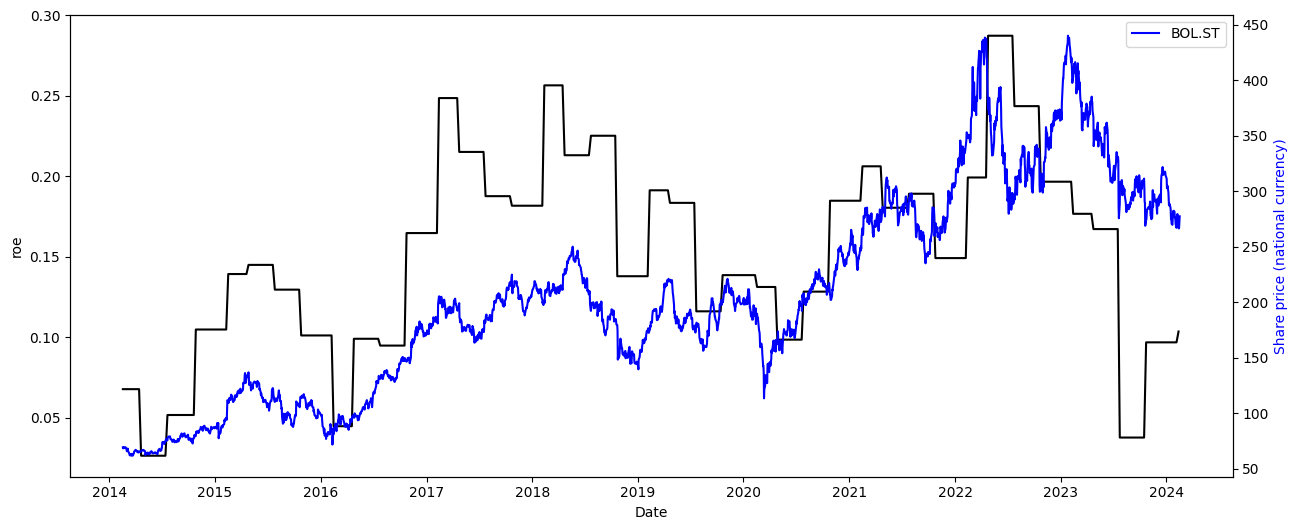

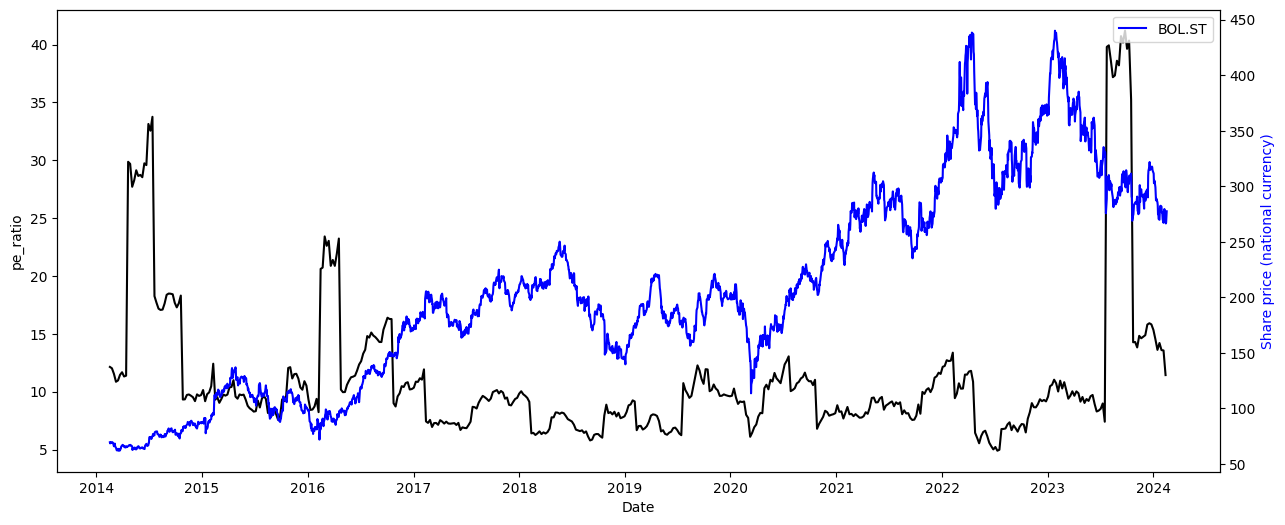

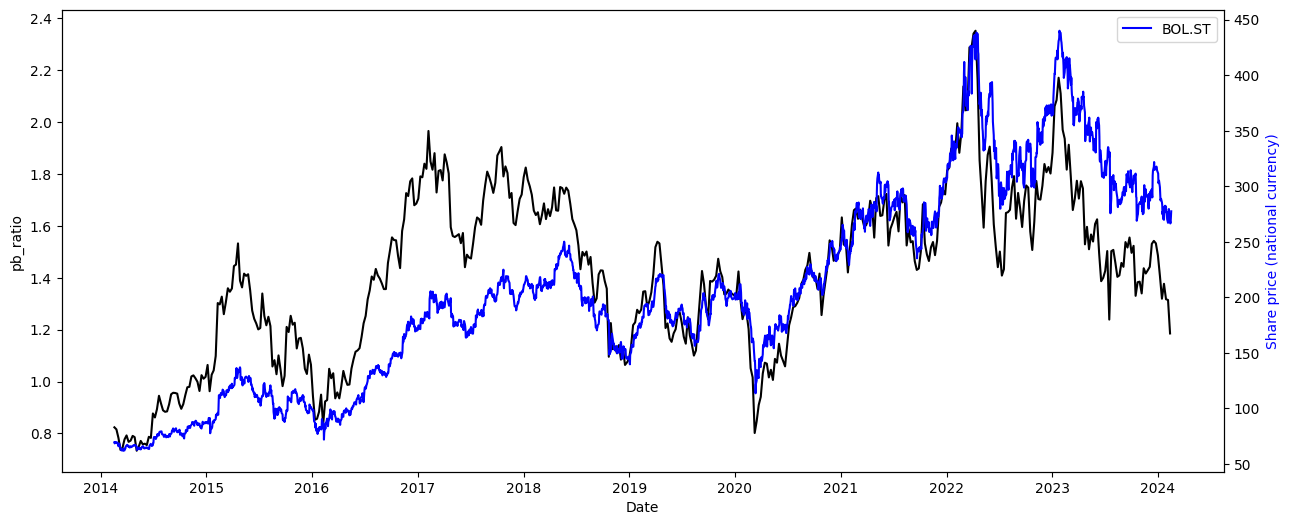

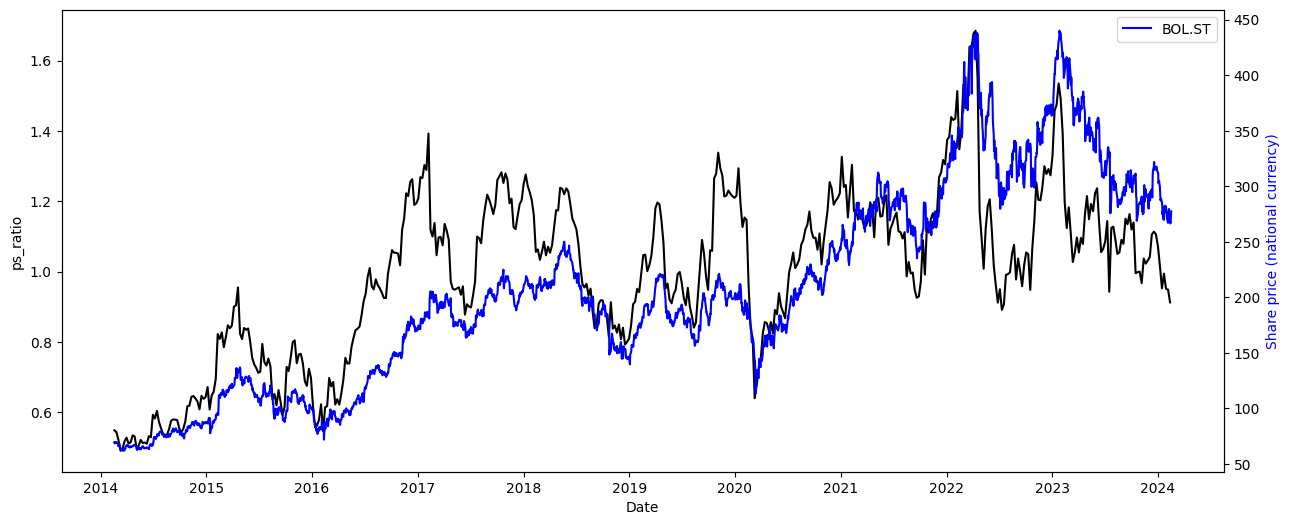

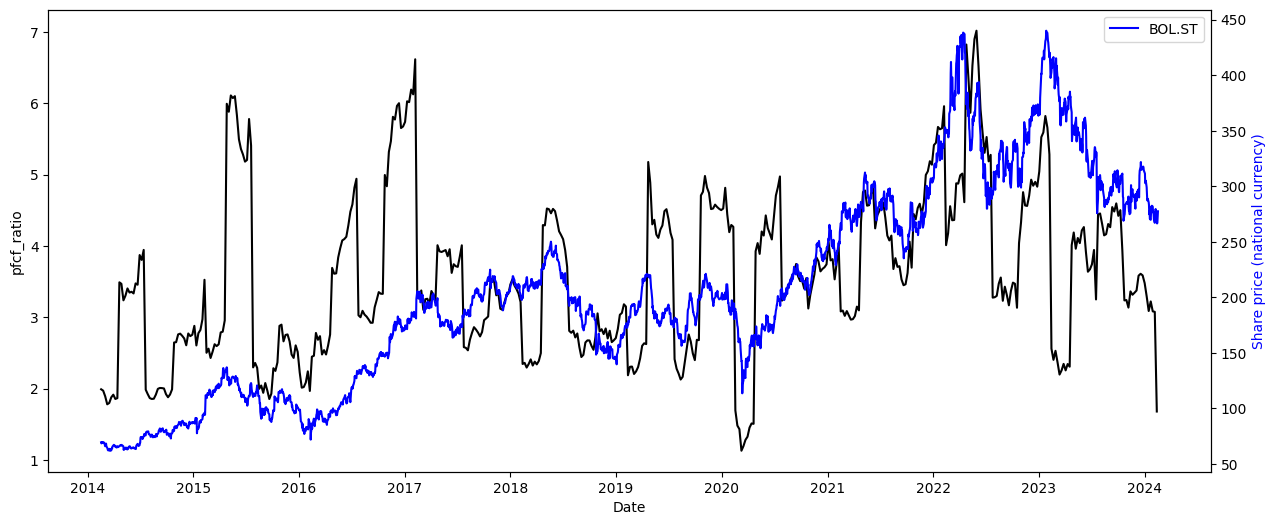

In [57]:
for column in merged_nok.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nok['real_date'], merged_nok[column], color='k', label=merged_nok)
    ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

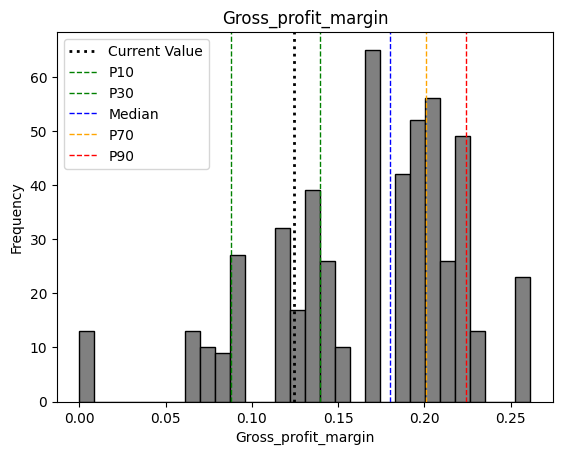

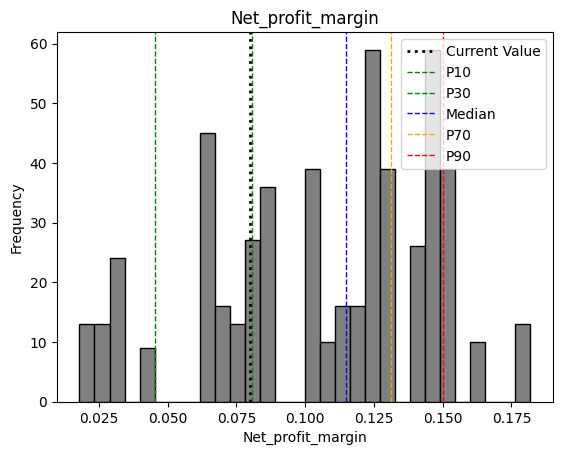

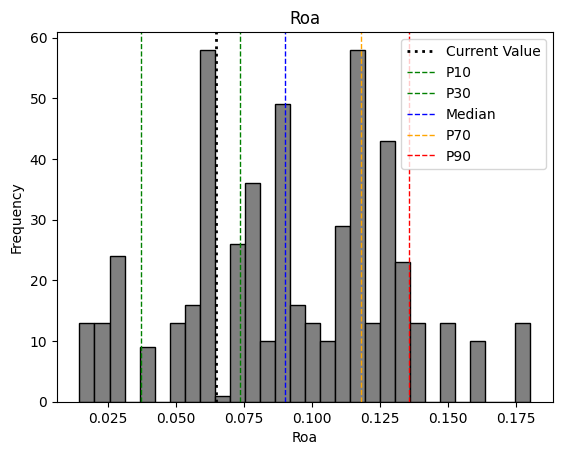

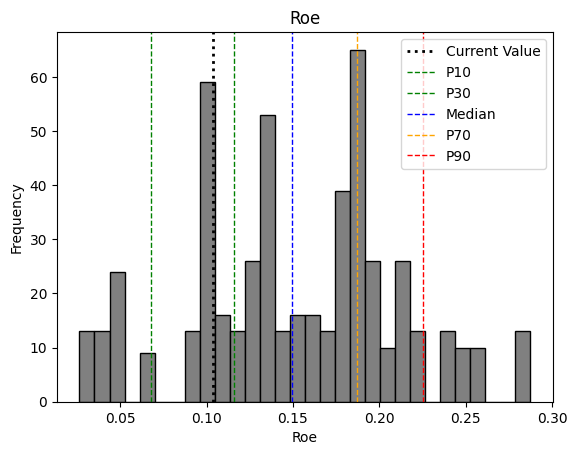

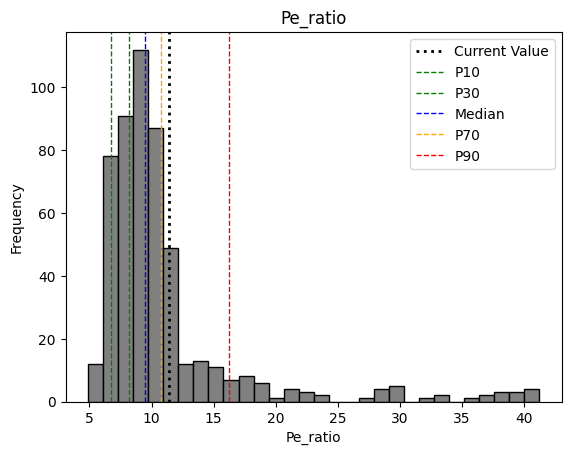

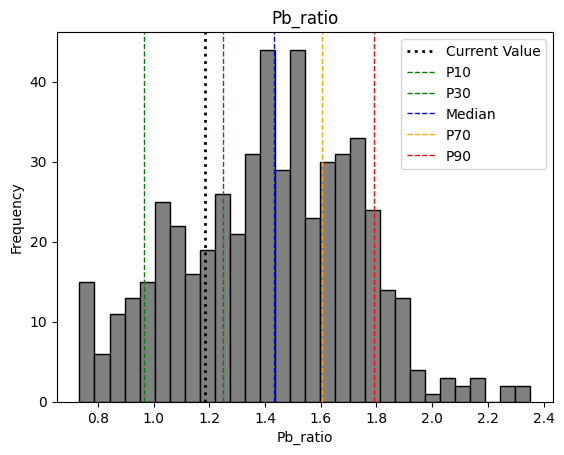

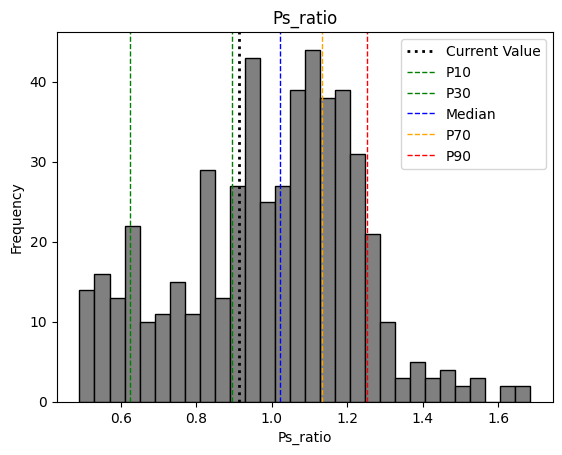

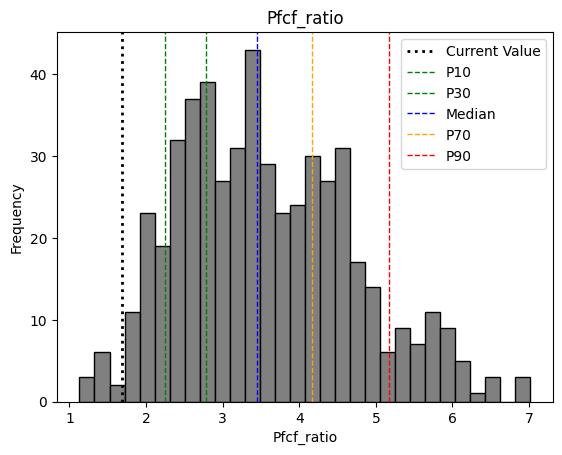

In [58]:
for column in merged_nok.columns[-8:]:
    try:
        plt.hist(merged_nok[column].values, bins=30, edgecolor='black', color='gray')
        plt.axvline(merged_nok[column].iloc[-1], color='k', linestyle='dotted', linewidth=2, label='Current Value')
        plt.axvline(merged_nok[column].quantile(0.1), color='green', linestyle='dashed', linewidth=1, label='P10')
        plt.axvline(merged_nok[column].quantile(0.3), color='green', linestyle='dashed', linewidth=1, label='P30')
        plt.axvline(merged_nok[column].quantile(0.5), color='blue', linestyle='dashed', linewidth=1, label='Median')
        plt.axvline(merged_nok[column].quantile(0.7), color='orange', linestyle='dashed', linewidth=1, label='P70')
        plt.axvline(merged_nok[column].quantile(0.9), color='red', linestyle='dashed', linewidth=1, label='P90')
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.title(column.capitalize())
        
        plt.legend()

        plt.show()
    except:
        print(column + " diagram is missing due to error.")

## Calculate correlation between value parameters

In [59]:
corr_matrix = pd.DataFrame(merged_nok, columns=['real_date', 'gross_profit_margin', 'net_profit_margin', 'roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'pfcf_ratio'])
# find independent columns
corr_matrix.corr()

,real_date,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
real_date,1.000000,0.358539,0.441362,0.402950,0.353459,-0.048743,0.540425,0.652320,0.325571
gross_profit_margin,0.358539,1.000000,0.891381,0.861493,0.860912,-0.615567,0.619135,0.584120,0.352478
net_profit_margin,0.441362,0.891381,1.000000,0.972294,0.958866,-0.729567,0.679242,0.654548,0.321169
roa,0.402950,0.861493,0.972294,1.000000,0.989924,-0.714460,0.664769,0.555108,0.266441
roe,0.353459,0.860912,0.958866,0.989924,1.000000,-0.719275,0.691600,0.545434,0.273544
pe_ratio,-0.048743,-0.615567,-0.729567,-0.714460,-0.719275,1.000000,-0.255710,-0.199172,0.009795
pb_ratio,0.540425,0.619135,0.679242,0.664769,0.691600,-0.255710,1.000000,0.902161,0.493846
ps_ratio,0.652320,0.584120,0.654548,0.555108,0.545434,-0.199172,0.902161,1.000000,0.549585
pfcf_ratio,0.325571,0.352478,0.321169,0.266441,0.273544,0.009795,0.493846,0.549585,1.000000


In [60]:
tolerance = 0.2

In [61]:
npm = merged_nok[(merged_nok['net_profit_margin']<= merged_nok['net_profit_margin'].iloc[-1] * (1+tolerance)) & (merged_nok['net_profit_margin']>= merged_nok['net_profit_margin'].iloc[-1] * (1- tolerance))]['date'].values
roe = merged_nok[(merged_nok['roe']<= merged_nok['roe'].iloc[-1] * (1+tolerance)) & (merged_nok['roe']>= merged_nok['roe'].iloc[-1] * (1- tolerance))]['date'].values
per = merged_nok[(merged_nok['pe_ratio']<= merged_nok['pe_ratio'].iloc[-1] * (1+tolerance)) & (merged_nok['pe_ratio']>= merged_nok['pe_ratio'].iloc[-1] * (1- tolerance))]['date'].values
pbr = merged_nok[(merged_nok['pb_ratio']<= merged_nok['pb_ratio'].iloc[-1] * (1+tolerance)) & (merged_nok['pb_ratio']>= merged_nok['pb_ratio'].iloc[-1] * (1- tolerance))]['date'].values
psr = merged_nok[(merged_nok['ps_ratio']<= merged_nok['ps_ratio'].iloc[-1] * (1+tolerance)) & (merged_nok['ps_ratio']>= merged_nok['ps_ratio'].iloc[-1] * (1- tolerance))]['date'].values
pfcfr = merged_nok[(merged_nok['pfcf_ratio']<= merged_nok['pfcf_ratio'].iloc[-1] * (1+tolerance)) & (merged_nok['pfcf_ratio']>= merged_nok['pfcf_ratio'].iloc[-1] * (1- tolerance))]['date'].values

In [62]:
def list_intersect(input1, input2):
    result = [x for x in input1 if x in input2]
    return result

In [63]:
test3 =  list_intersect(npm, roe)
test4 =  list_intersect(test3, per)
test5 =  list_intersect(test4, pbr)
test6 =  list_intersect(test5, psr)
test7 =  list_intersect(test6, pfcfr)
print(len(test7), 'timestemos have been found!')

17 timestemos have been found!


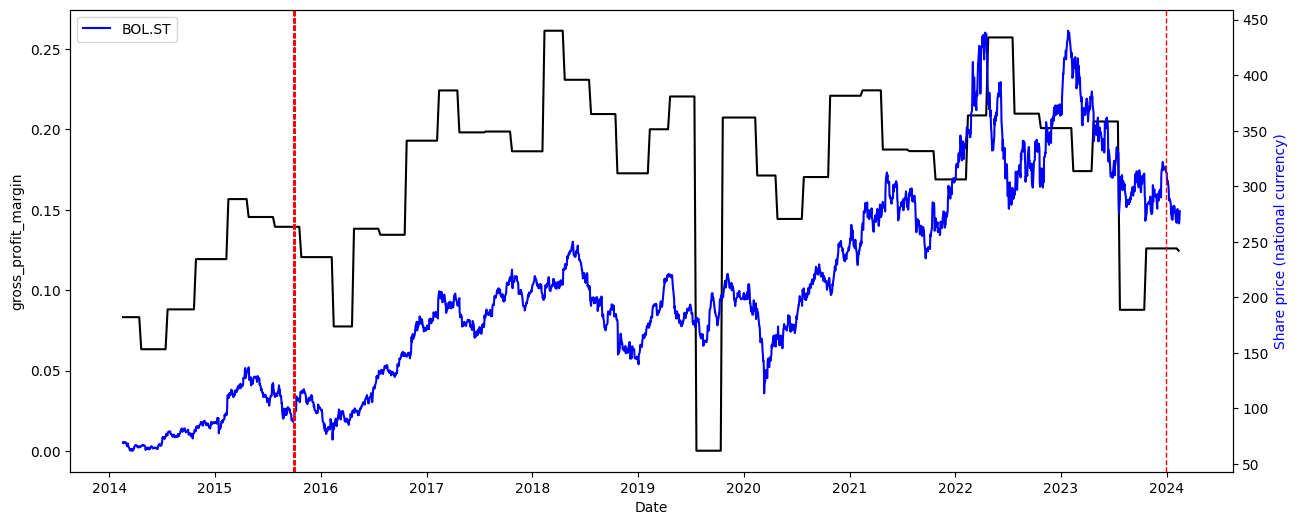

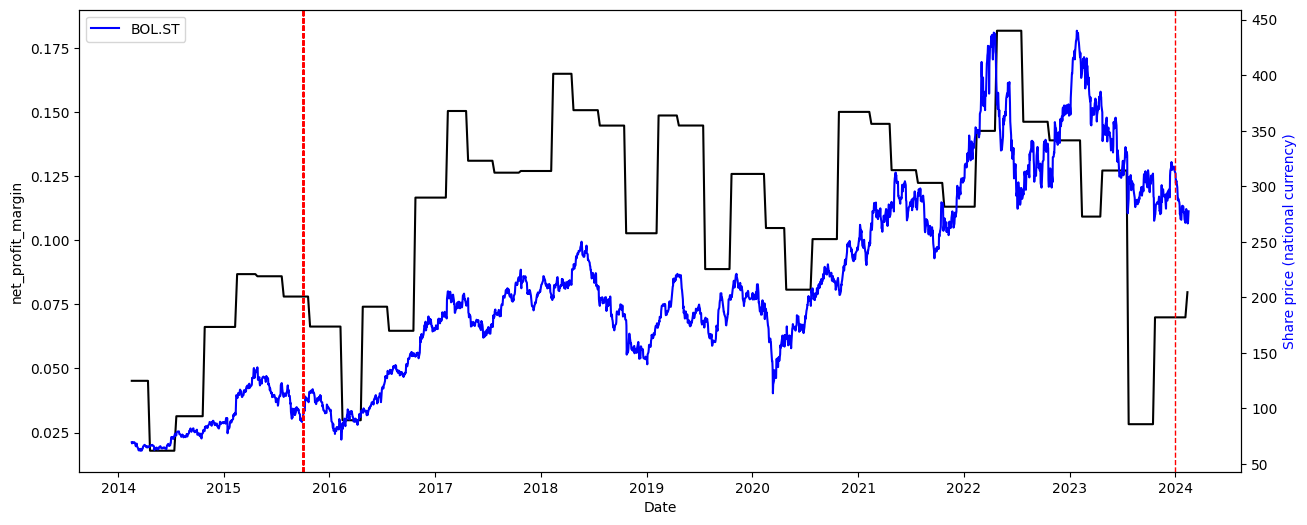

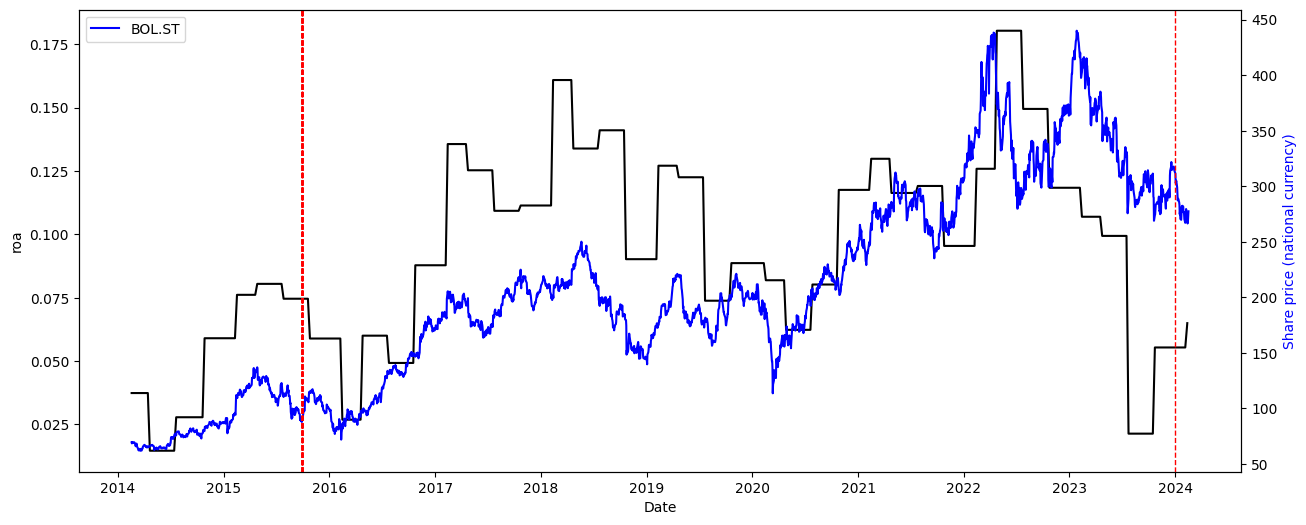

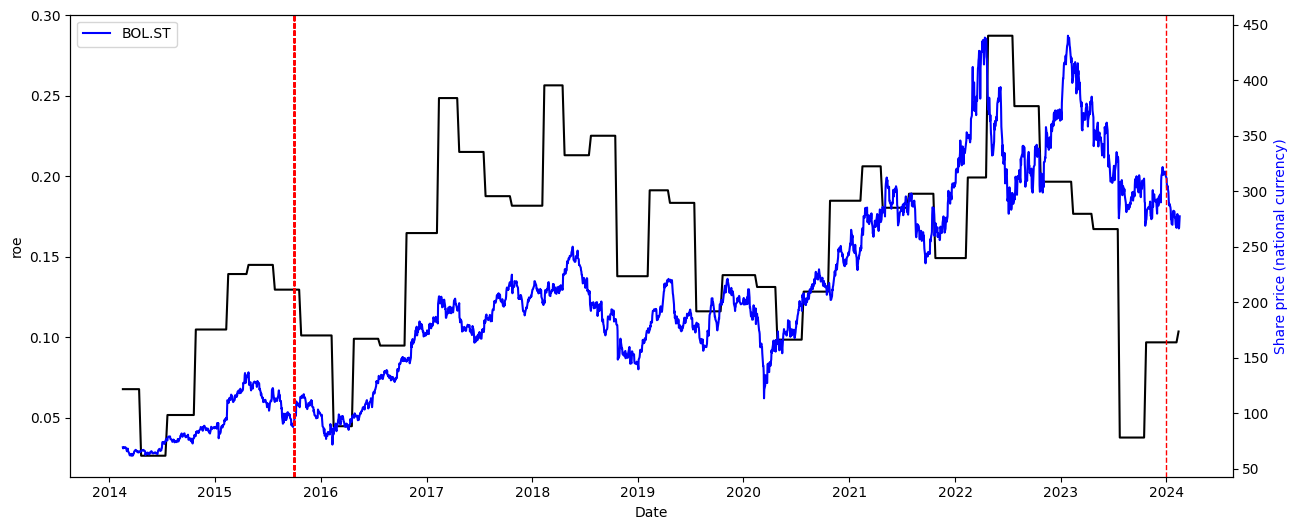

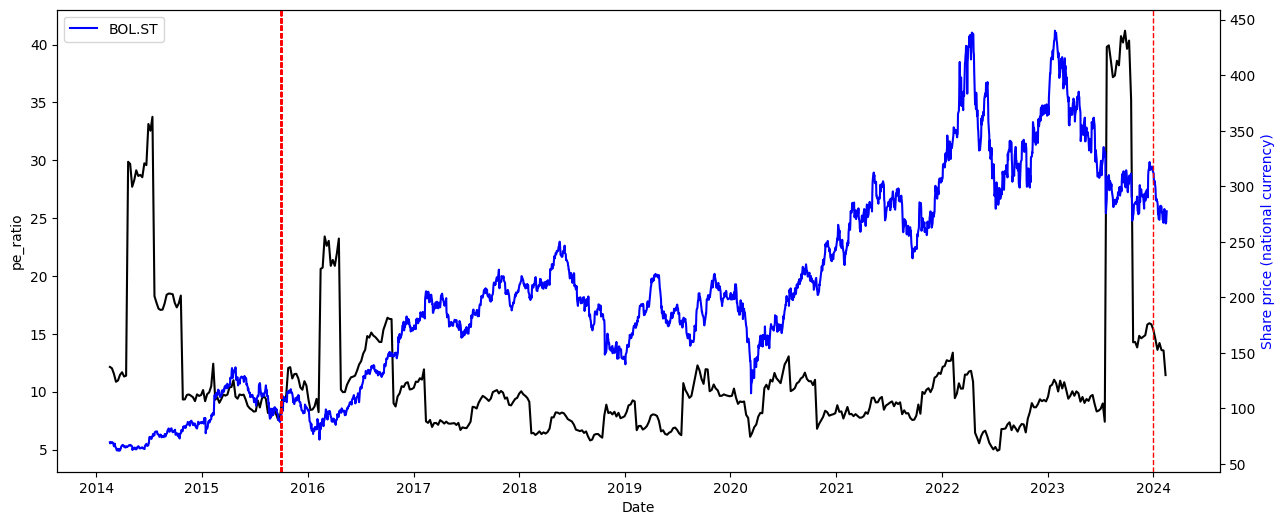

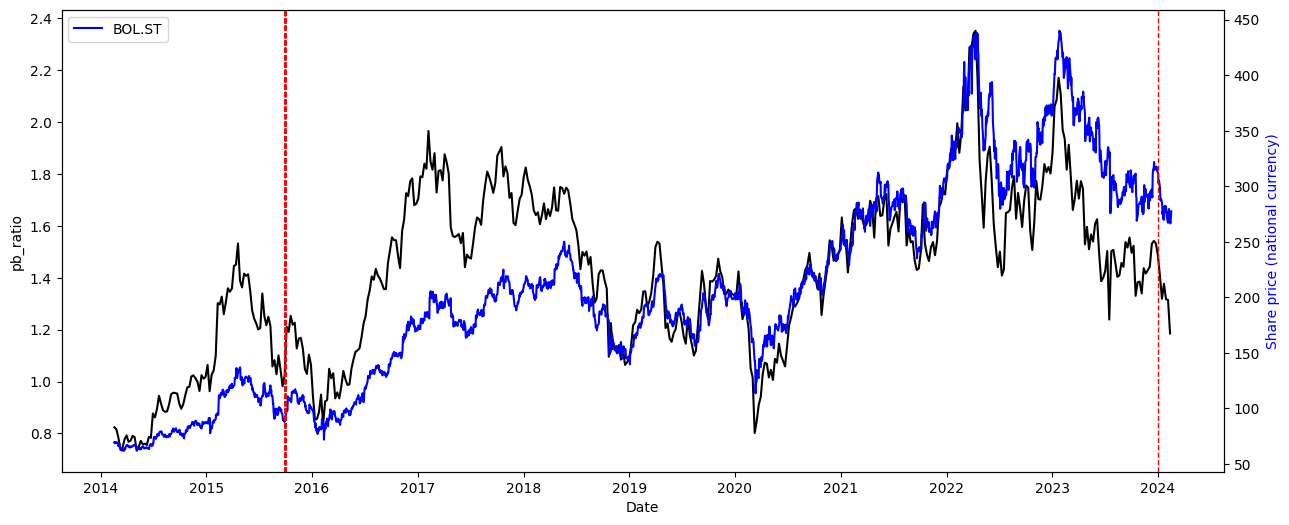

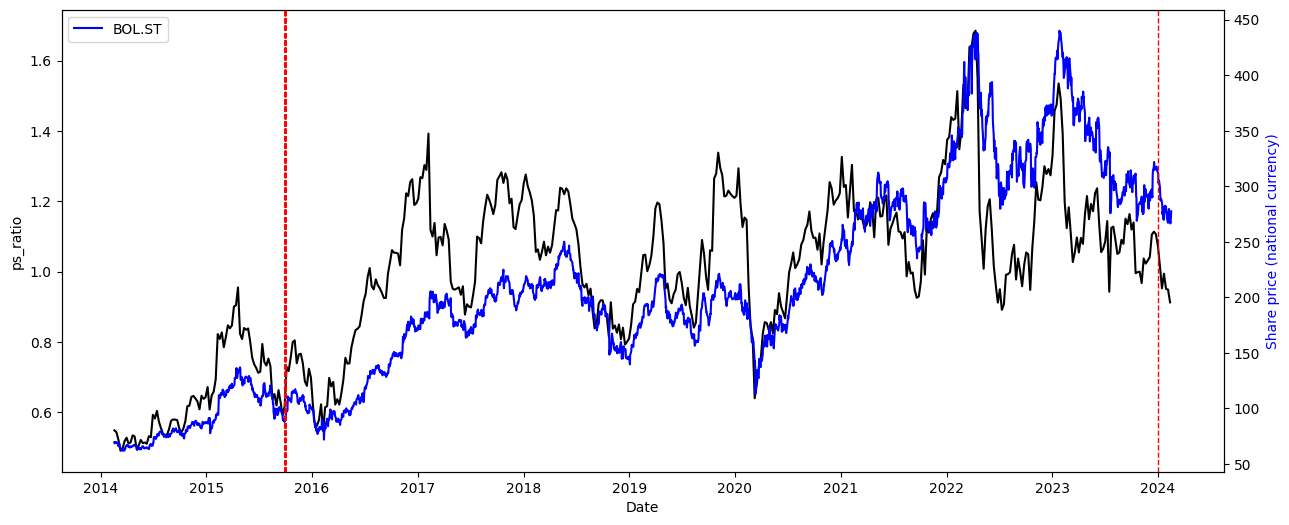

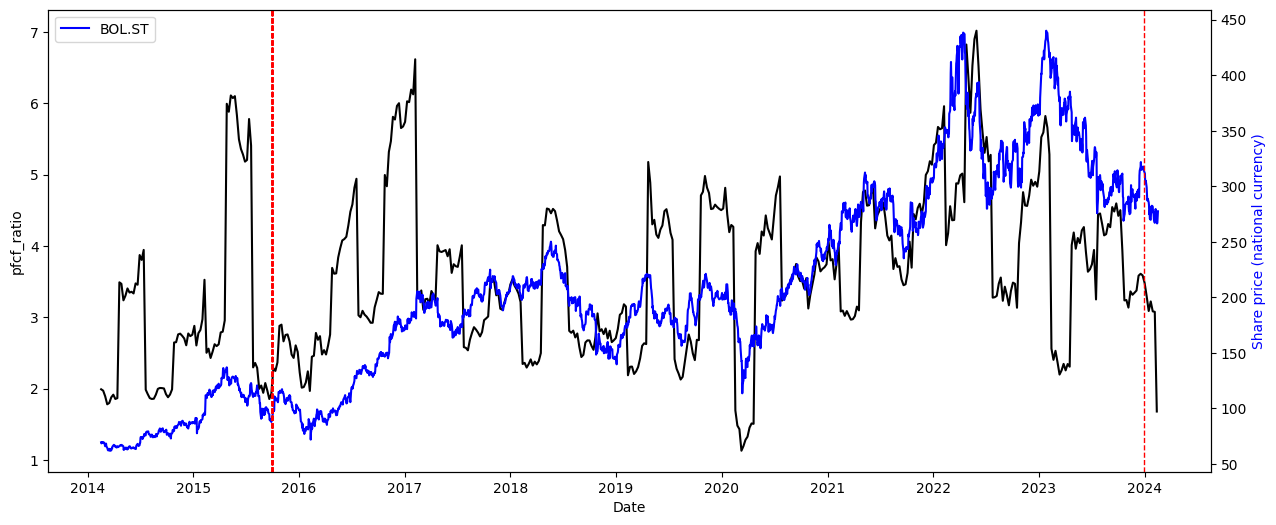

In [64]:
for column in merged_nok.columns[-8:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nok['real_date'], merged_nok[column], color='k', label=merged_nok)
    ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    for timestamp in test7:
        plt.axvline(timestamp, color='red', linestyle='dashed', linewidth=1)

    plt.legend()
    plt.show()